In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

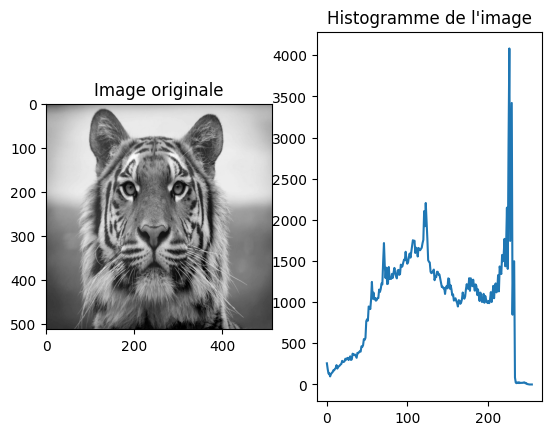

In [2]:
# lecture de l'image et conversion en niveaux de gris
img = cv2.imread('08.png', cv2.IMREAD_GRAYSCALE)
hist_img, bin_edges_img = np.histogram(img,bins=256,range=(0,256))

################# affichage #################
plt.figure()
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Image originale')
plt.subplot(122)
plt.plot(hist_img)
plt.title('Histogramme de l\'image')
plt.show()

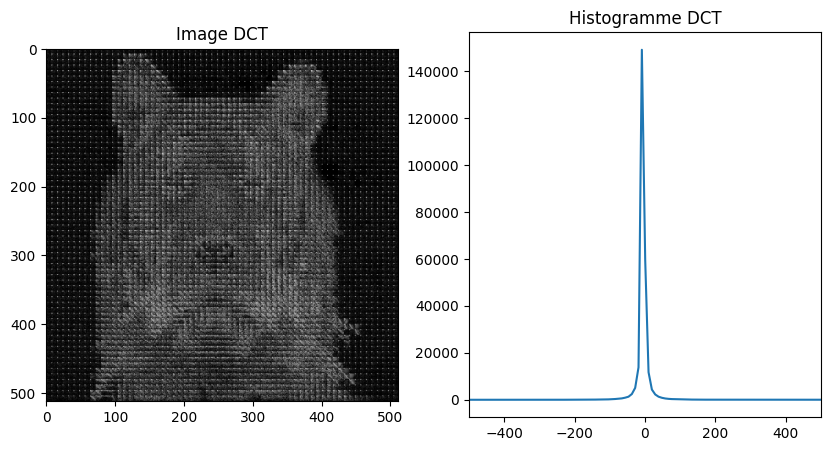

In [3]:
# division de l'image en imagettes 8x8 pixels
n = 8
h, w = img.shape
blocs = [img[j:j+n, i:i+n] for j in range(0,h,n) for i in range(0,w,n)] # liste des imagettes

# calcul de la DCT de chaque imagette
T_blocs = [cv2.dct(np.float32(bloc)) for bloc in blocs] # liste des DCT

# reconstruction de l'image à partir des DCT
T = np.zeros((h, w), np.float32)
for i, bloc in enumerate(T_blocs):
    x = (i * n) % w
    y = (i * n) // w * n
    T[y:y+n, x:x+n] = bloc

T_log = np.log1p(np.abs(T))

hist_dct, bin_edges_dct = np.histogram(T,bins=256)

################## affichage ##################
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(T_log, cmap='gray')
plt.title('Image DCT')
plt.subplot(122)
plt.plot(bin_edges_dct[0:-1],hist_dct)
plt.xlim([-500,500])
plt.title('Histogramme DCT')
plt.show()

[[ 32  22  20  32  48  80 102 122]
 [ 24  24  28  38  52 116 120 110]
 [ 28  26  32  48  80 114 138 112]
 [ 28  34  44  58 102 174 160 124]
 [ 36  44  74 112 136 218 206 154]
 [ 48  70 110 128 162 208 226 184]
 [ 98 128 156 174 206 242 240 202]
 [144 184 190 196 224 200 206 198]]


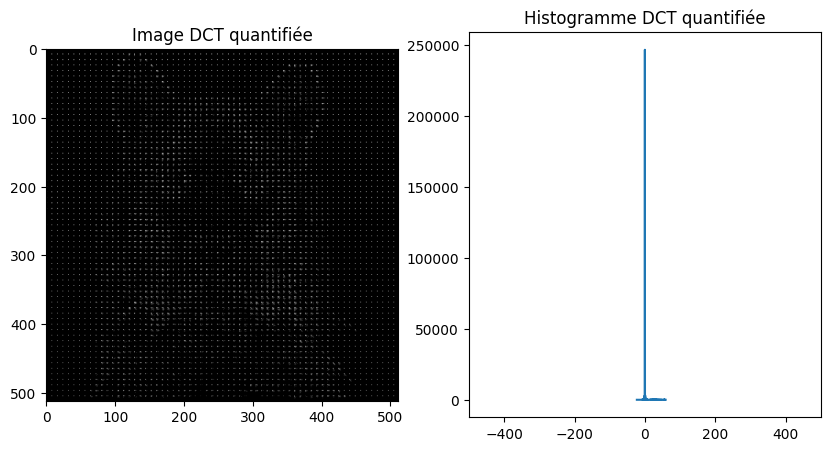

In [4]:
# matrice de quantification JPEG

Z = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])
Z = 2*Z
print(Z)

# DCT tronquée/quantifiée

x,y = T.shape

T_chap_blocs = [np.fix(bloc/Z) for bloc in T_blocs]

T_chap = np.zeros((h, w), np.float32)

for i, bloc in enumerate(T_chap_blocs):
    x = (i * n) % w
    y = (i * n) // w * n
    T_chap[y:y+n, x:x+n] = bloc

T_chap_log = np.log1p(np.abs(T_chap))
hist_T_chap, bin_edges_T_chap = np.histogram(T_chap,bins=256)

############### affichage #################
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(T_chap_log, cmap='gray')
plt.title('Image DCT quantifiée')
plt.subplot(122)
plt.plot(bin_edges_T_chap[0:-1],hist_T_chap)
plt.xlim([-500,500])
plt.title('Histogramme DCT quantifiée')
plt.show()

In [5]:
# encodage JPEG

def generate_zigzag_indices(n):
    indices = []
    for s in range(2 * n - 1):
        if s % 2 == 0:  # Parcours descendant
            for i in range(max(0, s - n + 1), min(n, s + 1)):
                indices.append((s - i, i))
        else:  # Parcours ascendant
            for i in range(max(0, s - n + 1), min(n, s + 1)):
                indices.append((i, s - i))
    return indices


zigzag_indices = generate_zigzag_indices(8)
zigzag_indices_flat = np.array([i * 8 + j for i, j in zigzag_indices])
print(zigzag_indices_flat)


T_pos_blocs = [(bloc != 0).astype(int) for bloc in T_chap_blocs]    # liste des matrices de positions (1 si != 0, 0 sinon)
T_pos_zigzag_blocs = [bloc.flatten()[zigzag_indices_flat] for bloc in T_pos_blocs]   # liste des matrices de position en zigzag
T_val_zigzag_blocs = [bloc.flatten()[zigzag_indices_flat] for bloc in T_chap_blocs]  # liste des matrices de valeurs en zigzag
T_val_blocs = [bloc[bloc != 0] for bloc in T_val_zigzag_blocs]      # liste des matrices de valeurs non nulles

print(T_pos_zigzag_blocs[0])
print(T_pos_blocs[0])

[ 0  1  8 16  9  2  3 10 17 24 32 25 18 11  4  5 12 19 26 33 40 48 41 34
 27 20 13  6  7 14 21 28 35 42 49 56 57 50 43 36 29 22 15 23 30 37 44 51
 58 59 52 45 38 31 39 46 53 60 61 54 47 55 62 63]
[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [6]:
def min_bits_to_code(values):
    """
    Retourne le nombre de bits minimum nécessaires pour coder tous les nombres dans la liste,
    en tenant compte des nombres négatifs et positifs.
    """

    # Convertir les valeurs en entiers Python pour pouvoir utiliser bit_length()
    int_values = map(int, values)
    # Trouver la valeur absolue maximale
    max_value = max(map(abs, int_values))
    num_bits = max_value.bit_length()
    
    # Si la liste contient des nombres négatifs, ajouter 1 bit pour le signe
    if any(val < 0 for val in values):
        num_bits += 1

    return num_bits

In [7]:
# Calcul de la mémoire

# Taille d'un élément de T_pos_zigzag_blocs
taille_T_pos_zigzag_blocs = 0
for bloc in T_pos_zigzag_blocs:
    taille_T_pos_zigzag_blocs += len(bloc)

# Taille d'un élément de T_val_blocs
taille_T_val_blocs = 0
for bloc in T_val_blocs:
    # min_bits = min_bits_to_code(bloc)
    # taille_T_val_blocs += min_bits * len(bloc)
    taille_T_val_blocs += 8 * len(bloc)

# Taille totale
taille_totale = taille_T_pos_zigzag_blocs + taille_T_val_blocs

# Taux de compression
compression_ratio = (h*w*8) / taille_totale

#################### affichage ####################
print("Taille totale : ", taille_totale)
print("Taille initiale : ", h*w*8)
print("Taux de compression : ", round(compression_ratio,2))

Taille totale :  383888
Taille initiale :  2097152
Taux de compression :  5.46


True


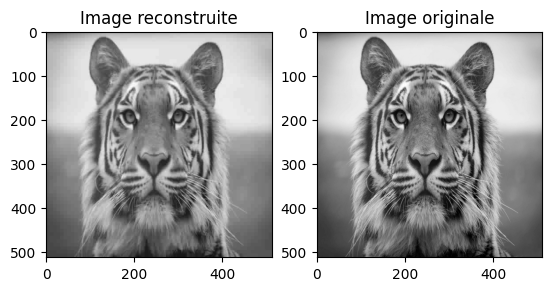

In [8]:
# Reconstruction de l'image à partir de T_chap (on fait l'inverse de ce qu'on a fait plus haut)

def reconstruct_val(position_vector, value_vector):
    """Reconstruit un vecteur 1D à partir des vecteurs de positions zigzag et de valeurs."""
    # Initialiser un vecteur vide de la taille de position_vector
    val = np.zeros(len(position_vector), dtype=int)

    value_index = 0
    for i in range(len(position_vector)):
        if position_vector[i] == 1:
            val[i] = value_vector[value_index]
            value_index += 1
    return val


def inverse_zigzag_order(vector):
    zigzag_indices = generate_zigzag_indices(8)
    zigzag_indices_flat = np.array([i * 8 + j for i, j in zigzag_indices])

    matrix = np.zeros(64, dtype=int)
    for i in range(64):
        matrix[zigzag_indices_flat[i]] = vector[i]
    
    return matrix.reshape((8, 8))

# Reconstruction des blocs de valeurs et de positions
T_val_zigzag_blocs_reconstruit = [reconstruct_val(pos, val) for pos, val in zip(T_pos_zigzag_blocs, T_val_blocs)]
T_chap_blocs_reconstruit = [inverse_zigzag_order(bloc) for bloc in T_val_zigzag_blocs_reconstruit]

print(np.array_equal(T_chap_blocs_reconstruit, T_chap_blocs))


T_reconstruit = [bloc*Z for bloc in T_chap_blocs_reconstruit]
T_reconstruit_img = [cv2.idct(np.float32(bloc)) for bloc in T_reconstruit]

img_reconstruit = np.zeros((h, w), np.float32)
for i, bloc in enumerate(T_reconstruit_img):
    x = (i * n) % w
    y = (i * n) // w * n
    img_reconstruit[y:y+n, x:x+n] = bloc

#################### affichage ####################
plt.figure()
plt.subplot(121)
plt.imshow(img_reconstruit, cmap='gray')
plt.title('Image reconstruite')
plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.title('Image originale')
plt.show()


In [9]:
# Qualité de l'image reconstruite
mse = np.mean((img - img_reconstruit) ** 2)
PSNR = 10 * np.log10(255**2 / mse)

print("PSNR : ", PSNR)

PSNR :  28.82558


In [10]:
# codage des valeurs non nulles par plage

def run_length_encoding(X,n_bit):

    if len(X) == 0:
        return []

    maximum = 0
    for i in range(n_bit):
        maximum+=2**i
    # Liste pour stocker les paires (valeur, longueur)
    encoded = []
    
    # Initialisation des variables
    current_value = X[0]
    count = 1
    value = 0

    # si la première valeur est 1, on ajoute un 0 pour le codage
    if current_value == 0:
        value = 1
        encoded.append(0)

    # Parcours du vecteur à partir du deuxième élément
    for i in range(1, len(X)):
        if count==maximum:
            encoded.append(count)
            current_value = X[i]  # Changer de valeur
            if current_value!=value : 
                encoded.append(0)
                if value == 1 :
                    value = 0
                else :
                    value = 1
            if value == 1 :
                value = 0
            else :
                value = 1
            count = 0 
        if X[i] == current_value:
            count += 1  # Si la valeur est identique, on augmente le compteur
        else:
            encoded.append(count)
            current_value = X[i]  # Changer de valeur
            if current_value!=value : 
                encoded.append(0)
                if value == 1 :
                    value = 0
                else :
                    value = 1
            if value == 1 :
                value = 0
            else :
                value = 1
            count = 1  # Réinitialiser le compteur

    # Ajouter la dernière plage
    encoded.append(count)
    
    return encoded

# codage des valeurs non nulles par plage
codage = [run_length_encoding(bloc, 3) for bloc in T_pos_zigzag_blocs]
# codage = run_length_encoding(T_pos_zigzag_blocs[0], 3)
print(T_pos_zigzag_blocs[0])
print(codage[0])


[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1, 1, 1, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 7, 0, 5]


In [11]:
# Calcul de la mémoire avec le codage par plage

# Taille d'un élément de T_pos_zigzag_blocs
taille_T_pos_codage_blocs = 0
for bloc in codage:
    taille_T_pos_codage_blocs += 3*len(bloc)

# Taille totale
taille_totale_codage = taille_T_pos_codage_blocs + taille_T_val_blocs

# Taux de compression
compression_ratio_codage = (h*w*8) / taille_totale_codage

############## affichage ##############
print("Taille totale : ", taille_totale_codage)
print("Taille initiale : ", h*w*8)
print("Taux de compression : ", round(compression_ratio_codage,2))

Taille totale :  358228
Taille initiale :  2097152
Taux de compression :  5.85


In [12]:
# Optimisation 
# On veut diminuer la valeur maximale de la liste des valeurs non nulles pour diminuer la taille de la liste des positions
# La valeur maximale se situe toujours en premier dans la liste des valeurs non nulles
# En parcourant les blocs, on va prendre pour le premier bloc la valeur de base
# Pour les blocs suivants, on va prendre la valeur de base - la valeur du bloc précédent

T_val_opt = [bloc.copy() for bloc in T_val_blocs]
print((T_val_blocs[1]))

previous = 0

for i in range(0,len(T_val_opt)):
    # print(i)
    if len(T_val_opt[i])!=0:
        new = T_val_opt[i][0] - previous
        previous = T_val_opt[i][0]
        T_val_opt[i][0] = new
    else :
        new = 0 - previous
        previous = 0
        T_val_opt[i] = [- previous]


# Calcul de la mémoire avec codage par plage et optimisation

# Taille d'un élément de T_val_opt
taille_T_val_opt = 0   

for bloc in T_val_opt:
    min_bits = min_bits_to_code(bloc)
    taille_T_val_opt += min_bits * len(bloc)

# Taille totale
taille_totale_opt = taille_T_pos_codage_blocs + taille_T_val_opt

# Taux de compression
compression_ratio_opt = (h*w*8) / taille_totale_opt

############## affichage ##############
print("Taille totale : ", taille_totale_opt)
print("Taille initiale : ", h*w*8)
print("Taux de compression : ", round(compression_ratio_opt,2))


[23. -2.]
Taille totale :  298227
Taille initiale :  2097152
Taux de compression :  7.03
